In [65]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import ast
import warnings
warnings.filterwarnings("ignore")

## Dataframe muestra de Reviews de Yelp:

In [53]:
scrapped_yelp = pd.read_csv('yelp_reviews_all_muestra_chica.csv')

In [54]:
scrapped_yelp

,review_text
0,Dinner at Melisse was better than expected. Th...
1,This well overdue and excited to come back thi...
2,We love coming here for special occasions!! We...
3,I came here during Covid. I had an allergy and...
4,"Food was great, wine pairings were great, serv..."
...,...
905,Service is fantastic and the food is sublime l...
906,This place is overrated and overpriced. I took...
907,Annual extravagant (belated) birthday dinner! ...
908,Quality of food and service is wonderful. Howe...


## 1) Prueba de Modelo de Análisis de Sentimientos:

In [55]:
'''Tomamos la tabla de reseñas y aplicamos dos análisis de sentimiento'''
# Reemplazamos 'review' con el nombre real de la columna en nuestro DataFrame que contiene las reseñas
reviews = scrapped_yelp['review_text']

# Analizamos el sentimiento de cada reseña y almacenamos los resultados en una nueva columna
scrapped_yelp['sentiment'] = reviews.apply(lambda review: TextBlob(review).sentiment)

# Imprimimos el DataFrame con los sentimientos
print(scrapped_yelp[['review_text', 'sentiment']])

                                           review_text  \
0    Dinner at Melisse was better than expected. Th...   
1    This well overdue and excited to come back thi...   
2    We love coming here for special occasions!! We...   
3    I came here during Covid. I had an allergy and...   
4    Food was great, wine pairings were great, serv...   
..                                                 ...   
905  Service is fantastic and the food is sublime l...   
906  This place is overrated and overpriced. I took...   
907  Annual extravagant (belated) birthday dinner! ...   
908  Quality of food and service is wonderful. Howe...   
909  Only True review! True experience!This is by f...   

                                      sentiment  
0      (0.2022857142857143, 0.6590793650793652)  
1     (0.2702205882352941, 0.47328431372549024)  
2     (0.2804278689147111, 0.49138376243639403)  
3     (0.36904761904761907, 0.5099206349206349)  
4     (0.22689075630252103, 0.7350840336134453)  
.. 

In [56]:

'''Extraemos estadísticas sobre ambos conceptos de sentimientos'''

# Analizamos el sentimiento y creamos las columnas de polaridad y subjetividad
scrapped_yelp['polarity'] = reviews.apply(lambda review: TextBlob(review).sentiment.polarity)
scrapped_yelp['subjectivity'] = reviews.apply(lambda review: TextBlob(review).sentiment.subjectivity)

# Calculamos las estadísticas básicas para la polaridad y la subjetividad
polarity_mean = scrapped_yelp['polarity'].mean()
subjectivity_mean = scrapped_yelp['subjectivity'].mean()

polarity_min = scrapped_yelp['polarity'].min()
polarity_max = scrapped_yelp['polarity'].max()

subjectivity_min = scrapped_yelp['subjectivity'].min()
subjectivity_max = scrapped_yelp['subjectivity'].max()

# Mostramos las estadísticas básicas
print(f"Polaridad - Media: {polarity_mean}, Mínimo: {polarity_min}, Máximo: {polarity_max}")
print(f"Subjetividad - Media: {subjectivity_mean}, Mínimo: {subjectivity_min}, Máximo: {subjectivity_max}")

# Porcentaje de polaridad positiva, neutral y negativa
total_reviews = len(scrapped_yelp)

positive_reviews = len(scrapped_yelp[scrapped_yelp['polarity'] > 0])
negative_reviews = len(scrapped_yelp[scrapped_yelp['polarity'] < 0])
neutral_reviews = len(scrapped_yelp[scrapped_yelp['polarity'] == 0])

positive_percentage = (positive_reviews / total_reviews) * 100
negative_percentage = (negative_reviews / total_reviews) * 100
neutral_percentage = (neutral_reviews / total_reviews) * 100

# Imprimimos los porcentajes
print(f"Reseñas Positivas: {positive_percentage:.2f}%")
print(f"Reseñas Neutrales: {neutral_percentage:.2f}%")
print(f"Reseñas Negativas: {negative_percentage:.2f}%")

Polaridad - Media: 0.2657409288620421, Mínimo: -0.20937499999999998, Máximo: 0.7083333333333334
Subjetividad - Media: 0.5447031096570002, Mínimo: 0.0, Máximo: 0.9375
Reseñas Positivas: 89.89%
Reseñas Neutrales: 2.20%
Reseñas Negativas: 7.91%


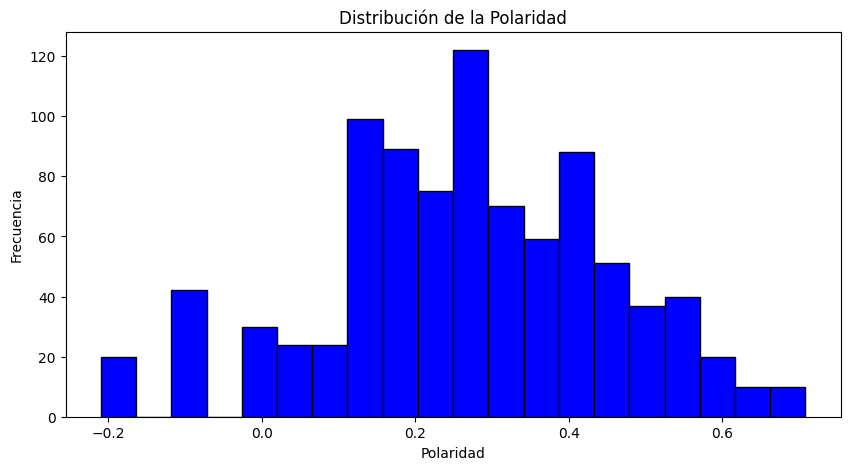

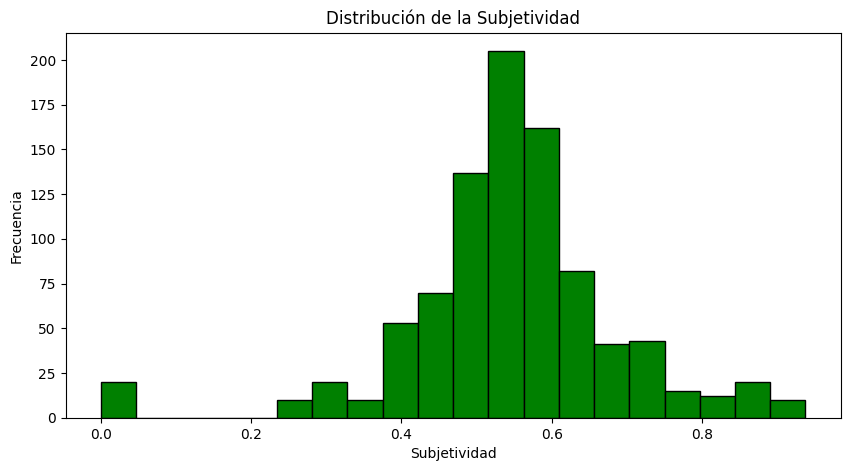

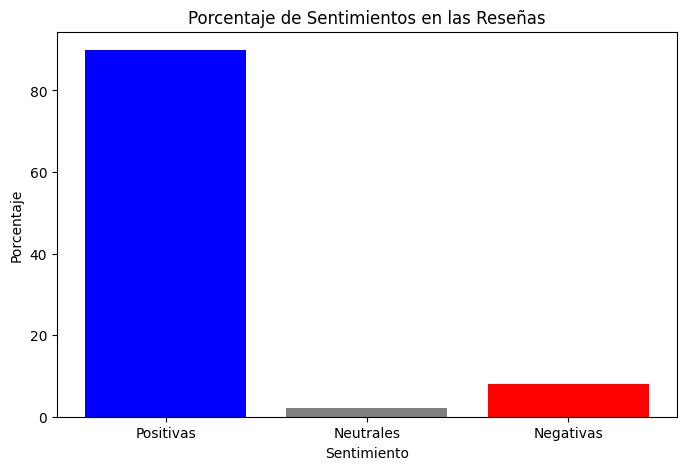

In [57]:
# Graficamos el histograma para la polaridad
plt.figure(figsize=(10, 5))
plt.hist(scrapped_yelp['polarity'], bins=20, color='blue', edgecolor='black')
plt.title('Distribución de la Polaridad')
plt.xlabel('Polaridad')
plt.ylabel('Frecuencia')
plt.show()

# Graficamos el histograma para la subjetividad
plt.figure(figsize=(10, 5))
plt.hist(scrapped_yelp['subjectivity'], bins=20, color='green', edgecolor='black')
plt.title('Distribución de la Subjetividad')
plt.xlabel('Subjetividad')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de barras para el porcentaje de reseñas positivas, neutrales y negativas
categorías = ['Positivas', 'Neutrales', 'Negativas']
porcentajes = [positive_percentage, neutral_percentage, negative_percentage]

plt.figure(figsize=(8, 5))
plt.bar(categorías, porcentajes, color=['blue', 'gray', 'red'])
plt.title('Porcentaje de Sentimientos en las Reseñas')
plt.xlabel('Sentimiento')
plt.ylabel('Porcentaje')
plt.show()

## Buscaremos trabajar con modelos sobre información de restaurantes.

In [58]:
business_ca = pd.read_csv('business_ca.csv')

In [67]:
business_ca.head(30)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,{},"Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{""Monday"": ""7:0-20:0"", ""Tuesday"": ""7:0-20:0"", ..."
1,sqSqqLy0sN8n2IZrAbzidQ,Domino's Pizza,3001 Highway 31 W,White House,CA,37188,36.464747,-86.659187,3.5,8,1,{},"Pizza, Chicken Wings, Sandwiches, Restaurants","{""Monday"": ""10:0-0:0"", ""Tuesday"": ""10:0-0:0"", ..."
2,LhpPSrulqVeTyJeK2xydvQ,Fresh Fruits & Salads,114 N 3rd St,Camden,CA,08102,39.946690,-75.123327,4.5,6,1,{},"Juice Bars & Smoothies, Restaurants, Fruits & ...","{""Monday"": ""9:0-18:0"", ""Tuesday"": ""9:0-18:0"", ..."
3,iPSPcprSnkLOuL1Ns8UZZA,Pete's Barber Shop,1209 N 29th St,Philadelphia,CA,19121,39.974880,-75.183262,4.5,12,1,{},"Barbers, Beauty & Spas",NaN
4,PYW8Buz8S8LpjIe6mZTAcw,Payless Liquors,954 N State Rd 135,Greenwood,CA,46143,39.632280,-86.158674,3.5,13,1,{},"Food, Beer, Wine & Spirits",NaN
5,8c0r7olQSYGcws0bTd3ikw,Zesty Tsunami,6614 Osteen Rd,New Port Richey,CA,34653,28.250218,-82.682441,4.0,5,0,{},"Hawaiian, Food, Food Trucks, Street Vendors, R...","{""Monday"": ""11:0-23:0"", ""Tuesday"": ""11:0-23:0""..."
6,pYC5fKcpj8GKjSAc7Sl3RQ,Main Exchange Barber Shop,3108 N Boundary Blvd,Tampa,CA,33602,27.862363,-82.498121,2.0,7,1,{},"Barbers, Beauty & Spas",NaN
7,QWqKTWQ2OiDgo3dzNkpung,Jong Ka Jib,6600 N 5th St,Philadelphia,CA,19126,40.052064,-75.127394,4.5,351,1,{},"Korean, Restaurants","{""Monday"": ""10:30-22:30"", ""Tuesday"": ""10:30-22..."
8,3uvFklejzRPwEPEZQ5vHYQ,Wawa,100 E Old Baltimore Pike,Media,CA,19063,39.916176,-75.387655,3.5,14,1,{},"Delis, Convenience Stores, Restaurants, Food, ...","{""Monday"": ""0:0-0:0"", ""Tuesday"": ""0:0-0:0"", ""W..."
9,jsQQu9rVerR3OGxIa0hRQQ,Kelly's Taproom,1107 Lancaster Ave,Bryn Mawr,CA,19010,40.024588,-75.324239,3.0,63,1,{},"Bars, Beer Bar, American (Traditional), Nightl...","{""Tuesday"": ""16:0-2:0"", ""Wednesday"": ""16:0-2:0..."


## Filtramos y visualizamos las ciudades con más restaurantes en California.

## 2) Probamos un modelo de recomendación de similitud del coseno con el objetivo de encontrar restaurantes similares al que le demos de referencia para poder evaluar posibles clientes potenciales.

In [61]:
def recommend_restaurants(restaurant_name, cosine_sim=cosine_sim):
    # Verificamos si el restaurante existe en el dataset
    if restaurant_name not in business_ca['name'].values:
        print(f"El restaurante '{restaurant_name}' no se encuentra en el dataset.")
        return None
    
    # Obtenemos el índice del restaurante que coincide con el nombre
    idx = business_ca[business_ca['name'] == restaurant_name].index[0]
    
    # Obtenemos las puntuaciones de similitud para este restaurante con todos los demás
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Ordenamos los restaurantes por puntuación de similitud
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Obtenemos los 10 restaurantes más similares
    sim_scores = sim_scores[1:11]
    
    # Obtenemos los índices de los restaurantes
    restaurant_indices = [i[0] for i in sim_scores]
    
    # Devolvemos los 10 restaurantes más similares
    return business_ca[['name', 'categories', 'stars']].iloc[restaurant_indices]

# Ejemplo: Recomendamos restaurantes similares a uno específico (reemplazar con un nombre de restaurante real)
recommended_restaurants = recommend_restaurants('Nombre Real del Restaurante')  # Reemplazar con un nombre real de restaurante
if recommended_restaurants is not None:
    print(recommended_restaurants)

El restaurante 'Nombre Real del Restaurante' no se encuentra en el dataset.


In [68]:
# Ejemplo: Recomendamos restaurantes similares a uno específico (reemplazar con un nombre de restaurante real)
recommended_restaurants = recommend_restaurants('Taco Del Mar')  # Reemplazar con un nombre real de restaurante
if recommended_restaurants is not None:
    print(recommended_restaurants)

                           name  \
668         Dia De Los Burritos   
1689              Tijuana Flats   
763                   Taco Bell   
2191  Alma's Tex Mex Restaurant   
1346                 Adobe Reds   
2069                  Taco Bell   
172              El Camino Real   
555      The Quesadilla Company   
214                   Taco Bell   
277                   Taco Bell   

                                             categories  stars  
668                       Mexican, Restaurants, Tex-Mex    4.0  
1689                      Tex-Mex, Restaurants, Mexican    4.0  
763     Mexican, Fast Food, Restaurants, Tacos, Tex-Mex    2.5  
2191  Tex-Mex, Food, Specialty Food, Restaurants, Me...    2.5  
1346                               Tex-Mex, Restaurants    3.0  
2069  American (Traditional), Tex-Mex, Fast Food, Re...    2.0  
172             Mexican, Tex-Mex, Restaurants, Barbeque    3.5  
555    Tex-Mex, Food, Food Trucks, Mexican, Restaurants    3.5  
214   Restaurants, Mexican, T

## 3) Probamos un modelo de vecinos cercanos para lograr efectivamente encontrar categorías de restaurantes apropiadas para buscar clientes.

In [69]:
# 1. Preprocesamiento de datos

# Supongamos que 'business_ca' es el DataFrame que contiene los datos de los restaurantes
# Procesamos 'stars' (característica numérica)
stars = business_ca[['stars']]

# Procesamos 'attributes' (listas de clave-valor)
# Convertimos la representación en cadena del diccionario a un formato de diccionario real
business_ca['attributes'] = business_ca['attributes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})
attributes_df = business_ca['attributes'].apply(pd.Series)

# Convertimos los valores booleanos ('True'/'False') en 1/0
attributes_df = attributes_df.replace({True: 1, False: 0})

# Procesamos 'categories' (listas de categorías)
# Utilizamos CountVectorizer para aplicar codificación one-hot a las categorías
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(', '))
categories_matrix = vectorizer.fit_transform(business_ca['categories'].fillna(''))

categories_df = pd.DataFrame(categories_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Combinamos todas las características procesadas en un solo DataFrame
X = pd.concat([stars, attributes_df.fillna(0), categories_df], axis=1)

# Estandarizamos los datos numéricos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Aplicación del algoritmo KNN
# Creamos un modelo KNN para encontrar los vecinos más cercanos
knn = NearestNeighbors(n_neighbors=10, metric='euclidean')  # Buscamos los 10 vecinos más cercanos
knn.fit(X_scaled)

def recommend_categories(restaurant_name, n_neighbors=10):
    # Buscamos el restaurante en el DataFrame
    if restaurant_name not in business_ca['name'].values:
        print(f"El restaurante '{restaurant_name}' no se encuentra en el dataset.")
        return None
    
    # Obtenemos el índice del restaurante
    idx = business_ca[business_ca['name'] == restaurant_name].index[0]
    
    # Encontramos los 'n_neighbors' más cercanos
    distances, indices = knn.kneighbors([X_scaled[idx]], n_neighbors=n_neighbors)
    
    # Extraemos los restaurantes más cercanos
    similar_restaurants = business_ca.iloc[indices[0]]
    
    # Analizamos las categorías de los restaurantes más cercanos
    categories = similar_restaurants['categories'].apply(lambda x: x.split(', ')).explode()
    
    # Contamos la frecuencia de cada categoría
    category_counts = categories.value_counts()
    
    print(f"Categorías más comunes entre los restaurantes similares a '{restaurant_name}':")
    print(category_counts.head())

# 3. Ejemplo de uso: Buscar categorías de clientes similares a un restaurante
recommend_categories('Taco Del Mar', n_neighbors=10)

Categorías más comunes entre los restaurantes similares a 'Taco Del Mar':
categories
Restaurants    10
Tex-Mex        10
Mexican         6
Fast Food       2
Food            2
Name: count, dtype: int64
